<h1> Problem

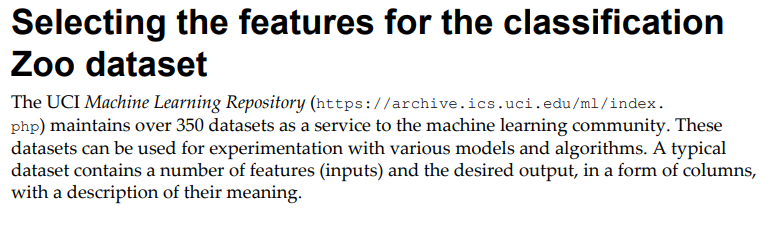

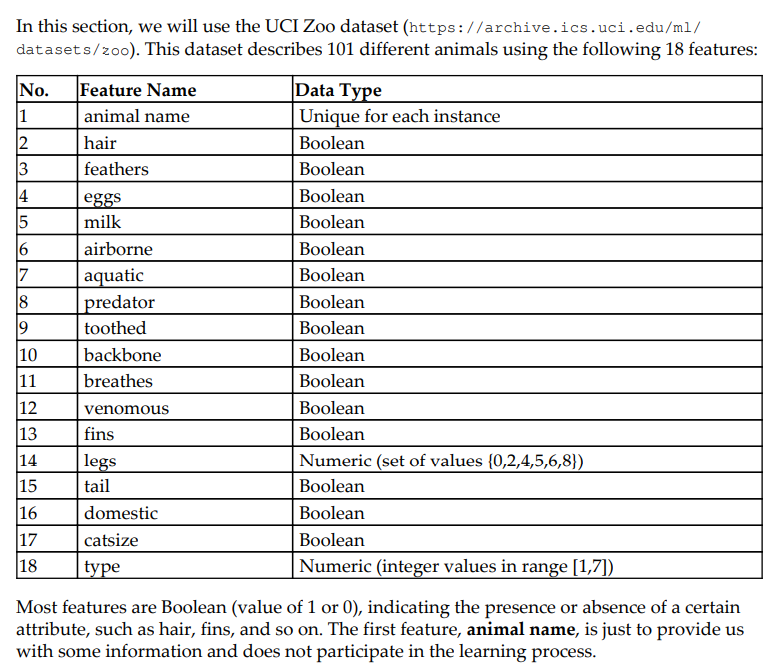

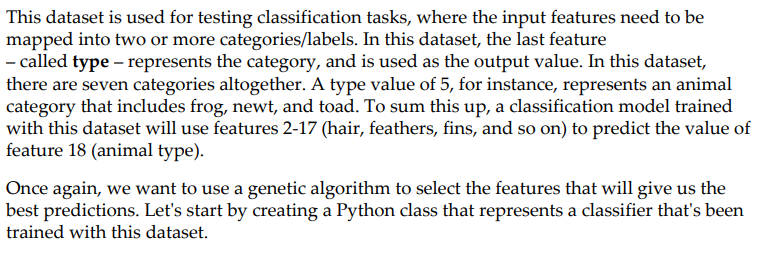

In [1]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1> Taking data

In [2]:
import requests

def baixarArquivo(url, saveDir):
  resposta = requests.get(url)
  if resposta.status_code == requests.codes.OK:         # requests.codes.OK = 200 ( Tudo ok com a url )
    with open(saveDir, "wb") as arquivo:        # Definindo o nome do diretório, abrindo um arquivo para ESCRITA na forma de BITS.
      arquivo.write(resposta.content)
      print(f"O download acabou e foi salvo em {saveDir}")
  else:
    resposta.raise_for_status()

DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data"
baixarArquivo(DATA_URL, "ZooData.csv")

O download acabou e foi salvo em ZooData.csv


In [3]:
import pandas as pd

df = pd.read_csv("ZooData.csv", header=None)
X = df.iloc[:, 1:17]
y = df.iloc[:, 17]



<h1> Fitness function

In [4]:
# For this problem we wil represent a solution of problem as a binary list [ 0 1 0 1 1 0 0 ... ]
# We will separe the data in train and test, but we will use "k-fold cross-validation"

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
import random
import numpy as np

# CONTROL PANEL
RANDOM_SEED = 42
SPLIT_DATA_NUMBER = 5
NUM_FEATURES = len(X.columns)
random.seed(RANDOM_SEED)

MODEL = DecisionTreeClassifier(random_state=RANDOM_SEED)
DATA_SPLITTER = KFold(n_splits=SPLIT_DATA_NUMBER)

def fitness_function(solution, MODEL, DATA_SPLITTER):
  global X, y

  if sum(solution) == 0:
    return 0,
  else:
    # Selecting data
    Indices = [i for i, n in enumerate(solution) if n == 0]
    currentX = X.drop(columns=X.columns[Indices])
    # Scoring
    scores = cross_val_score(MODEL, currentX, y, cv=DATA_SPLITTER, scoring="accuracy")

  return scores.mean(),

Primeiras 1 features(recursos): score = (0.5842857142857143,)
Primeiras 2 features(recursos): score = (0.7119047619047619,)
Primeiras 3 features(recursos): score = (0.7614285714285715,)
Primeiras 4 features(recursos): score = (0.7614285714285715,)
Primeiras 5 features(recursos): score = (0.7914285714285714,)
Primeiras 6 features(recursos): score = (0.8214285714285714,)
Primeiras 7 features(recursos): score = (0.8314285714285713,)
Primeiras 8 features(recursos): score = (0.8800000000000001,)
Primeiras 9 features(recursos): score = (0.9099999999999999,)
Primeiras 10 features(recursos): score = (0.9199999999999999,)
Primeiras 11 features(recursos): score = (0.9399999999999998,)
Primeiras 12 features(recursos): score = (0.9299999999999999,)
Primeiras 13 features(recursos): score = (0.93,)
Primeiras 14 features(recursos): score = (0.89,)
Primeiras 15 features(recursos): score = (0.9099999999999999,)
Primeiras 16 features(recursos): score = (0.9099999999999999,)


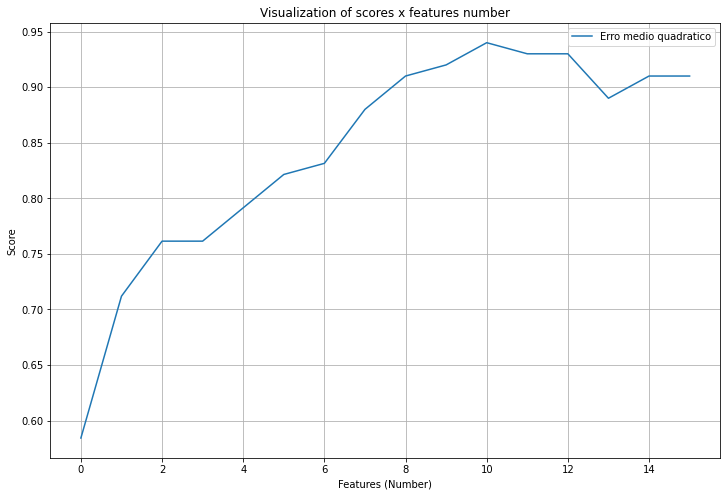

In [5]:
# Here we will teste how the model behaves changing the features number
import matplotlib.pyplot as plt

# CALCULATING
fitness = []
for i in range(NUM_FEATURES):
  solution = [1]*(i+1) + [0]*(NUM_FEATURES-(i+1))
  fitness.append(fitness_function(solution, MODEL, DATA_SPLITTER))
  print(f"Primeiras {i+1} features(recursos): score = {fitness[i]}")


# PLOTTING
plt.figure(figsize=(12,8))
plt.plot([i for i in range(NUM_FEATURES)], fitness, label="Erro medio quadratico")


# ENHANCING
plt.xlabel(xlabel="Features (Number)")
plt.ylabel(ylabel="Score")
plt.title("Visualization of scores x features number")
plt.legend()

plt.grid(b=True)
plt.show()

In [6]:
# Using all resources our best score was about 0.91

<h1> Solving the problem

In [7]:
from deap import creator, base, tools, algorithms
import random
import numpy as np


# STRUCTURE
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("ChromosomeStruct", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()


# GENE, CHROMOSOME, INDIVIDUAL, POPULATION
CHROMOSOME_LENGTH = NUM_FEATURES # Number of features to be selected
def geneBin():
  return random.randint(0,1)
toolbox.register("Gene", geneBin)
toolbox.register("Chromosome", tools.initRepeat, creator.ChromosomeStruct, toolbox.Gene, n=CHROMOSOME_LENGTH)
toolbox.register("Individual", toolbox.Chromosome)
toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.Individual)


# GENETIC OPERATORS 
toolbox.register("evaluate", fitness_function, MODEL=MODEL, DATA_SPLITTER=DATA_SPLITTER)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=2/CHROMOSOME_LENGTH)

  
# STORING THE INFORMATION
stats = tools.Statistics(lambda population: population.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("mean", np.mean)
def comparation(scores):
  score_all_feature = 0.91
  return np.max(scores)/0.91
stats.register("comparation", comparation)
hof = tools.HallOfFame(5)


# CONTROL PANEL
POPULATION_SIZE = 50
PROBABILITY_CROSSOVER = 0.8
PROBABILITY_MUTATION = 0.2
MAX_GENERATIONS = 20 # (stopping condition)
#random.seed(42)


# EVOLVING THE SOLUTION
generationCounter = 0
population = toolbox.PopulationCreator(n=POPULATION_SIZE)
result, logbook = algorithms.eaSimple(population,
                                      toolbox,
                                      cxpb=PROBABILITY_CROSSOVER,
                                      mutpb=PROBABILITY_MUTATION,
                                      ngen=MAX_GENERATIONS,
                                      stats=stats,
                                      halloffame=hof,
                                      verbose=True)

gen	nevals	max 	min    	mean    	comparation
0  	50    	0.94	0.59381	0.862495	1.03297    
1  	41    	0.95	0.810952	0.906914	1.04396    
2  	49    	0.94	0.811905	0.907752	1.03297    
3  	42    	0.94	0.661905	0.914133	1.03297    
4  	41    	0.95	0.84    	0.923048	1.04396    
5  	47    	0.95	0.9     	0.928286	1.04396    
6  	40    	0.95	0.91    	0.935295	1.04396    
7  	50    	0.95	0.88    	0.933562	1.04396    
8  	42    	0.95	0.860952	0.936676	1.04396    
9  	44    	0.95	0.88    	0.936305	1.04396    
10 	36    	0.95	0.88    	0.941657	1.04396    
11 	41    	0.95	0.88    	0.939067	1.04396    
12 	44    	0.950476	0.91    	0.941476	1.04448    
13 	41    	0.95    	0.75    	0.935657	1.04396    
14 	41    	0.95    	0.88    	0.940686	1.04396    
15 	47    	0.950476	0.86    	0.941714	1.04448    
16 	34    	0.96    	0.89    	0.943114	1.05495    
17 	42    	0.96    	0.91    	0.943933	1.05495    
18 	41    	0.96    	0.840476	0.942562	1.05495    
19 	40    	0.96    	0.910476	0.945429	1.05495    
20 	

<h1> Plotting results

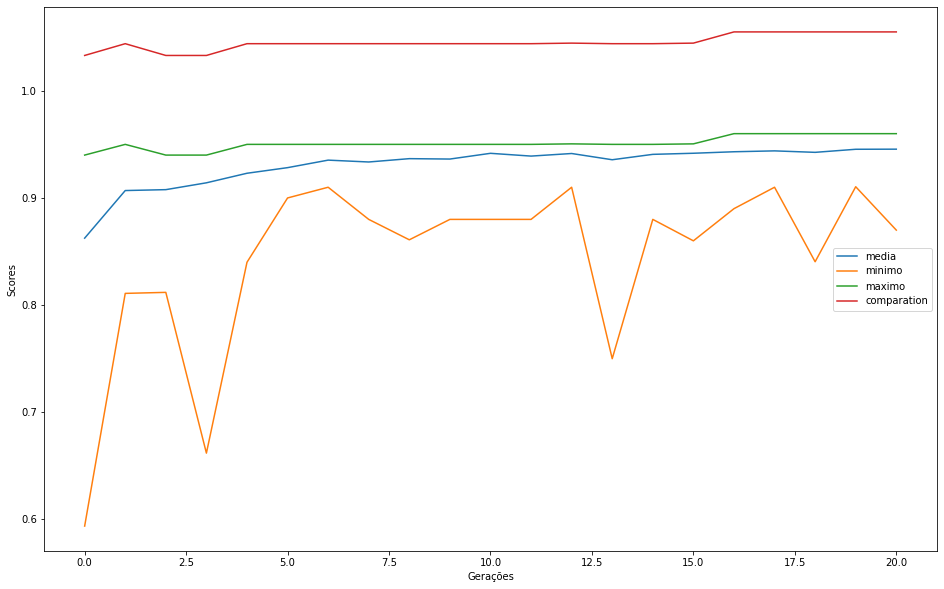

In [8]:
import matplotlib.pyplot as plt

# taking data
y_min = logbook.select("min")
y_max = logbook.select("max")
y_mean = logbook.select("mean")
y_comparation = logbook.select("comparation")
x_gen = logbook.select("gen")


#plotting
plt.figure(figsize=(16,  10))
plt.plot(x_gen, y_mean, label="media")
plt.plot(x_gen, y_min, label="minimo")
plt.plot(x_gen, y_max, label="maximo")
plt.plot(x_gen, y_comparation, label="comparation")


plt.xlabel("Gerações")
plt.ylabel("Scores")
plt.legend(loc=5)
plt.show()

<h1> Trying to improve the result with elitims and constraints

In [9]:
from deap import tools
from deap import algorithms

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [10]:
def fitness_function_changed(solution, MODEL, DATA_SPLITTER):
  global X, y

  if sum(solution) == 0:
    return 0,
  else:
    # Selecting data
    Indices = [i for i, n in enumerate(solution) if n == 0]
    currentX = X.drop(columns=X.columns[Indices])
    # Scoring
    scores = cross_val_score(MODEL, currentX, y, cv=DATA_SPLITTER, scoring="accuracy")
    score = scores.mean() - sum(solution)*0.001

  return score,

In [11]:
from deap import creator, base, tools, algorithms
import random
import numpy as np


# STRUCTURE
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("ChromosomeStruct", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()


# GENE, CHROMOSOME, INDIVIDUAL, POPULATION
CHROMOSOME_LENGTH = NUM_FEATURES # Number of features to be selected
def geneBin():
  return random.randint(0,1)
toolbox.register("Gene", geneBin)
toolbox.register("Chromosome", tools.initRepeat, creator.ChromosomeStruct, toolbox.Gene, n=CHROMOSOME_LENGTH)
toolbox.register("Individual", toolbox.Chromosome)
toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.Individual)


# GENETIC OPERATORS 
toolbox.register("evaluate", fitness_function_changed, MODEL=MODEL, DATA_SPLITTER=DATA_SPLITTER)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=2/CHROMOSOME_LENGTH)

  
# STORING THE INFORMATION
stats = tools.Statistics(lambda population: population.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("mean", np.mean)
def comparation(scores):
  score_all_feature = 0.91
  return np.max(scores)/0.91
stats.register("comparation", comparation)
hof2 = tools.HallOfFame(5)


# CONTROL PANEL
POPULATION_SIZE = 50
PROBABILITY_CROSSOVER = 0.8
PROBABILITY_MUTATION = 0.2
MAX_GENERATIONS = 20 # (stopping condition)
#random.seed(42)


# EVOLVING THE SOLUTION
generationCounter = 0
population = toolbox.PopulationCreator(n=POPULATION_SIZE)
result, logbook = eaSimpleWithElitism(population,
                                      toolbox,
                                      cxpb=PROBABILITY_CROSSOVER,
                                      mutpb=PROBABILITY_MUTATION,
                                      ngen=MAX_GENERATIONS,
                                      stats=stats,
                                      halloffame=hof2,
                                      verbose=True)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'ChromosomeStruct' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	max  	min    	mean   	comparation
0  	50    	0.944	0.59881	0.85429	1.03736    
1  	41    	0.944	0.66081	0.894183	1.03736    
2  	41    	0.961	0.851  	0.91449 	1.05604    
3  	37    	0.961	0.775  	0.923843	1.05604    
4  	37    	0.961	0.842  	0.930361	1.05604    
5  	40    	0.961	0.843  	0.934078	1.05604    
6  	39    	0.961	0.883  	0.935523	1.05604    
7  	37    	0.961	0.9    	0.943746	1.05604    
8  	39    	0.961	0.832952	0.939556	1.05604    
9  	39    	0.961	0.872476	0.944168	1.05604    
10 	35    	0.962	0.861476	0.947449	1.05714    
11 	41    	0.963	0.853952	0.952288	1.05824    
12 	35    	0.963	0.894   	0.95533 	1.05824    
13 	41    	0.963	0.864476	0.947427	1.05824    
14 	34    	0.963	0.912   	0.952088	1.05824    
15 	39    	0.963	0.678333	0.943552	1.05824    
16 	40    	0.963	0.872   	0.947786	1.05824    
17 	36    	0.964	0.875952	0.950546	1.05934    
18 	36    	0.964	0.854476	0.953129	1.05934    
19 	31    	0.964	0.747381	0.950747	1.05934    
20 	38    	0.964	0.76742

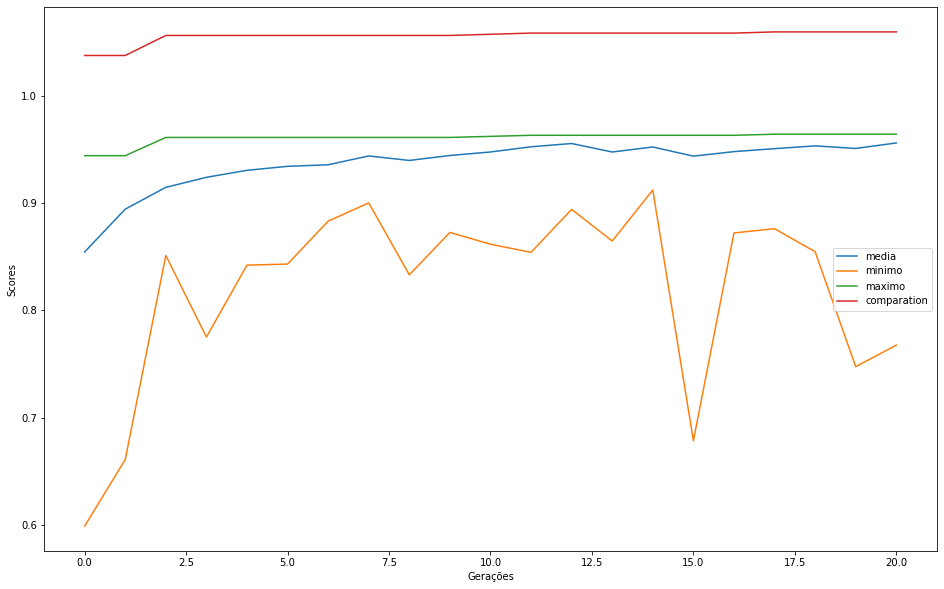

In [12]:
import matplotlib.pyplot as plt

# taking data
y_min = logbook.select("min")
y_max = logbook.select("max")
y_mean = logbook.select("mean")
y_comparation = logbook.select("comparation")
x_gen = logbook.select("gen")


#plotting
plt.figure(figsize=(16,  10))
plt.plot(x_gen, y_mean, label="media")
plt.plot(x_gen, y_min, label="minimo")
plt.plot(x_gen, y_max, label="maximo")
plt.plot(x_gen, y_comparation, label="comparation")


plt.xlabel("Gerações")
plt.ylabel("Scores")
plt.legend(loc=5)
plt.show()

<h1> Comparating the both methods

In [13]:
print("The first evolve")
for i in hof:
  print(f"{i} : fitness = {fitness_function_changed(i, MODEL, DATA_SPLITTER)} : accuracy = {fitness_function(i, MODEL, DATA_SPLITTER)} : features number = {sum(i)}")
print("\nThe second evolve")
for i in hof2:
  print(f"{i} : fitness = {fitness_function_changed(i, MODEL, DATA_SPLITTER)} : accuracy = {fitness_function(i, MODEL, DATA_SPLITTER)} : features number = {sum(i)}")

The first evolve
[0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0] : fitness = (0.954,) : accuracy = (0.96,) : features number = 6
[1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1] : fitness = (0.949,) : accuracy = (0.96,) : features number = 11
[1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1] : fitness = (0.9394761904761905,) : accuracy = (0.9504761904761905,) : features number = 11
[0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0] : fitness = (0.9424761904761905,) : accuracy = (0.9504761904761905,) : features number = 8
[1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0] : fitness = (0.9414761904761905,) : accuracy = (0.9504761904761905,) : features number = 9

The second evolve
[0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0] : fitness = (0.9640000000000001,) : accuracy = (0.9700000000000001,) : features number = 6
[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0] : fitness = (0.9630000000000001,) : accuracy = (0.9700000000000001,) : features number = 7
[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,

[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0] : fitness = (0.964,) : accuracy = (0.97,) : features number = 6
